In [1]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers import Dense
from keras.utils import np_utils
from imutils import paths
import numpy as np
import argparse
import glob
import cv2
import os
import matplotlib.pyplot as plt
#matplotlib.use("Agg")


/home/jorgher/.virtualenvs/cv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/jorgher/.virtualenvs/cv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def image_to_feature_vector(image, size=(128, 128)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

In [3]:
path = "/home/jorgher/Documents/faceRec/CFEE/train/"
directories = [x for x in os.walk(path)]
direc = sorted(directories)
# initialize the data matrix and labels list
data = []

for i in range(1,8):
    for j in range(0,230-1):
        imagepaths = path+'Emo_0'+str(i)+"/"+direc[i][2][j]
        data.append(imagepaths)


In [4]:
print("[INFO] construyendo vectores de intensidad...")
# loop over the input images
dat = []
labels = []
for imagePath in data[0:1602]:
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath,0)
    
    
    label = imagePath.split(os.path.sep)[-2].split("_")[1]
 
    # construct a feature vector raw pixel intensities, then update
    # the data matrix and labels list
    features = image_to_feature_vector(image)
    dat.append(features)
    labels.append(label)


[INFO] construyendo vectores de inensidad...


In [5]:
# encode the labels, converting them from strings to integers
le = LabelEncoder()
labels = le.fit_transform(labels)
 
# scale the input image pixels to the range [0, 1], then transform
# the labels into vectors in the range [0, num_classes] -- this
# generates a vector for each label where the index of the label
# is set to `1` and all other entries to `0`
data = np.array(dat) / 255.0
labels = np_utils.to_categorical(labels, 7)
 
# partition the data into training and testing splits, using 75%
# of the data for training and the remaining 25% for testing
print("[INFO] generando training/testing data...")
(trainData, testData, trainLabels, testLabels) = train_test_split(data, labels, test_size=0.25, random_state=42)

[INFO] generando training/testing data...


In [6]:
trainData.shape,trainLabels.shape

((1201, 16384), (1201, 7))

In [7]:
# define the architecture of the network
model = Sequential()
model.add(Dense(3000, input_dim=16384, kernel_initializer="uniform", activation="relu"))
model.add(Dense(500, kernel_initializer="uniform", activation="relu"))
model.add(Dense(7))
model.add(Activation("softmax"))

In [8]:
# train the model using SGD
print("[INFO] compilando el modelo...")
sgd = SGD(lr=0.01)
model.compile(loss="binary_crossentropy", optimizer=sgd,metrics=["accuracy"])
H = model.fit(trainData, trainLabels, validation_split=0.33, epochs=10, batch_size=128, verbose=1)

[INFO] compilando el modelo...
Train on 804 samples, validate on 397 samples
Epoch 1/10
804/804 [==============================] - 8s 10ms/step - loss: 0.7109 - acc: 0.8133 - val_loss: 1.3985 - val_acc: 0.7632
Epoch 2/10
804/804 [==============================] - 7s 8ms/step - loss: 3.0575 - acc: 0.7573 - val_loss: 3.9519 - val_acc: 0.7531
Epoch 3/10
804/804 [==============================] - 7s 8ms/step - loss: 3.0338 - acc: 0.7523 - val_loss: 1.6311 - val_acc: 0.7478
Epoch 4/10
804/804 [==============================] - 7s 9ms/step - loss: 1.2404 - acc: 0.7706 - val_loss: 1.0303 - val_acc: 0.7661
Epoch 5/10
804/804 [==============================] - 7s 8ms/step - loss: 0.6772 - acc: 0.8351 - val_loss: 0.4440 - val_acc: 0.8568
Epoch 6/10
804/804 [==============================] - 7s 8ms/step - loss: 0.4220 - acc: 0.8571 - val_loss: 0.4240 - val_acc: 0.8571
Epoch 7/10
804/804 [==============================] - 7s 9ms/step - loss: 0.4127 - acc: 0.8571 - val_loss: 0.4296 - val_acc: 0.857

In [9]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(testData, testLabels,batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

[INFO] evaluating on testing set...
401/401 [==============================] - 1s 3ms/step
[INFO] loss=0.4257, accuracy: 85.7143%


In [10]:
print("Grabando los coeficientes al archivo...")
model.save_weights('Emo_weights.hdf5', overwrite=True)

Grabando los coeficientes al archivo...


In [11]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Emotion Classification")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("ClasEMo.png")


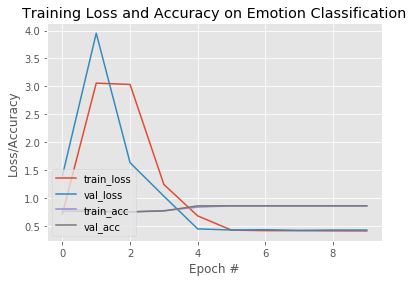

In [12]:
plt.show()